LangChain - Workflow And Agents

https://mirror-feeling-d80.notion.site/Workflow-And-Agents-17e808527b1780d792a0d934ce62bee6

In [1]:
from dotenv import load_dotenv, find_dotenv
import os 

_ = load_dotenv(find_dotenv())

In [2]:
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, List, Optional
from operator import add 
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain.output_parsers import PydanticOutputParser


# Define Writing State in workflow
class WritingState(TypedDict):
    messages: Annotated[List[BaseMessage], add] # 使用 Annotated 和 add 来合并列表
    outline: Optional[str]
    draft: Optional[str]
    final_draft: Optional[str]
    intent_analysis: Optional[dict]
    

# create intent analysis pydantic outparser 
class IntentAnalysis(BaseModel):
    core_intent: str = Field(description="用户的核心写作意图")
    key_topics: List[str] = Field(description="需要覆盖的关键主题列表")
    additional_aspects: List[str] = Field(description="用户可能没有想到但值得包含的相关方面")


# create user intent analysis func 
def analyze_user_intent(state: WritingState) -> dict:
    """analysis intent and expand from user's input
    """
    intent_llm = ChatOpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
        base_url=os.getenv("OPENAI_BASE_URL"),
        model="gpt-4o",
        temperature=0.7
    )
    parser = PydanticOutputParser(pydantic_object=IntentAnalysis)
    format_instructions = parser.get_format_instructions()
    messages = state["messages"]
    query = messages[0].content
    response = intent_llm.invoke([
        HumanMessage(content=f"""请分析以下写作请求，并提供详细分析：
                        写作请求: {query}
                        请确保返回符合下面格式的响应。{format_instructions}""")
    ])
    
    # 解析输出
    try:
        parsed_response = parser.parse(response.content)
        analysis_dict = parsed_response.dict()
        
        # 创建人类可读的总结
        readable_summary = f"""分析结果：
            核心意图：{analysis_dict['core_intent']}
            关键主题：{chr(10).join('- ' + topic for topic in analysis_dict['key_topics'])}
            额外建议方面：{chr(10).join('- ' + aspect for aspect in analysis_dict['additional_aspects'])}"""
        
        return {
            "messages": [
                AIMessage(content=readable_summary)
            ],
            "intent_analysis": analysis_dict  # 将结构化的分析结果存储在状态中
        }
    except Exception as e:
        return {
            "messages": [
                AIMessage(content=f"分析过程出现错误: {str(e)}\n原始响应: {response.content}")
            ],
            "intent_analysis": None
        }
    
    
# create generate outline func 
def generate_outline(state: WritingState) -> dict:
    """Generate Article Outline from analyzed intent
    """
    outline_llm = ChatOpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
        base_url=os.getenv("OPENAI_BASE_URL"),
        model="gpt-4o",
        temperature=0.6
    )
    
    messages = state["messages"]
    original_query = messages[0].content
    analysis = state.get("intent_analysis", {})
    # 构建提示
    prompt = f"""基于以下写作需求和分析，生成一个详细的文章大纲:
                 写作需求: {original_query}
                分析结果:
                核心意图: {analysis.get('core_intent', '未提供')}
                关键主题: {', '.join(analysis.get('key_topics', ['未提供']))}
                建议补充方面: {', '.join(analysis.get('additional_aspects', ['未提供']))}

                请生成一个结构清晰的大纲，确保涵盖所有关键主题和建议的补充方面。"""

    response = outline_llm.invoke([HumanMessage(content=prompt)])
    
    return {
        "outline": response.content,
        "messages": [AIMessage(content=f"已生成大纲: {response.content}")]
    }
    
# create draft writing func
def write_draft(state: WritingState) -> dict:
    """Write Draft"""
    draft_llm = ChatOpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
        base_url=os.getenv("OPENAI_BASE_URL"),
        model="claude-3-5-sonnet",
        temperature=0.6
    )
    outline = state["outline"]
    response = draft_llm.invoke([
        HumanMessage(content=f"根据以下大纲写一篇文章: {outline}")
    ])
    return {
        "draft": response.content,
        "messages": [AIMessage(content="已完成初稿")]
    }
    
# create article proofread func
def proofread(state: WritingState) -> dict:
    """校对和修改"""
    proofread_llm = ChatOpenAI(
        api_key=os.getenv("OPENAI_API_KEY"),
        base_url=os.getenv("OPENAI_BASE_URL"),
        model="gpt-4o",
        temperature=0.6
    )
    draft = state["draft"]
    response = proofread_llm.invoke([
        HumanMessage(content=f"请校对并改进以下文章,给出修改后的版本: {draft}")
    ])
    return {
        "final": response.content,
        "messages": [AIMessage(content="校对完成。")] 
    }
    

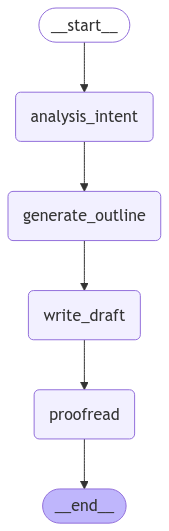

In [3]:
# construct workflow
from langgraph.graph import StateGraph, START, END
write_workflow = StateGraph(WritingState)

# add workflow
write_workflow.add_node("analysis_intent", analyze_user_intent)
write_workflow.add_node("generate_outline", generate_outline)
write_workflow.add_node("write_draft", write_draft)
write_workflow.add_node("proofread", proofread)

# add edge
write_workflow.add_edge(START, "analysis_intent")
write_workflow.add_edge("analysis_intent", "generate_outline")
write_workflow.add_edge("generate_outline", "write_draft")
write_workflow.add_edge("write_draft", "proofread")
write_workflow.add_edge("proofread", END)

# set up entrance 
write_workflow.set_entry_point("analysis_intent")

# compile graph
chain = write_workflow.compile()

# show graph topology
from IPython.display import Image, display
display(Image(chain.get_graph().draw_mermaid_png()))

In [4]:
# 1. 首先创建初始状态
initial_state = {
    "messages": [HumanMessage(content="请写一篇关于LLM发展历史的文章")],
    "outline": None,
    "draft": None,
    "final_draft": None,
    "intent_analysis": None
}

# 2. 执行工作流
# 方法1：直接获取最终结果
result = chain.invoke(initial_state)

# 方法2：如果想看到执行过程，可以使用 stream 模式
# stream_mode = "values": 显示每一步后的完整状态
# stream_mode = "updates": 只显示每一步的更新内容
# stream_mode = "debug": 显示调试信息
for step in chain.stream(initial_state, stream_mode="debug"):
    print("\n=== Step Output ===")
    print("Current Node:", list(step.keys())[0])  # 显示当前执行的节点
    print("Node Output:", step[list(step.keys())[0]])  # 显示节点的输出

/var/folders/ch/9x3s3x05791_bpgv82bf5wlm0000gn/T/ipykernel_71086/1890276327.py:48: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  analysis_dict = parsed_response.dict()



=== Step Output ===
Current Node: type
Node Output: task


/var/folders/ch/9x3s3x05791_bpgv82bf5wlm0000gn/T/ipykernel_71086/1890276327.py:48: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  analysis_dict = parsed_response.dict()



=== Step Output ===
Current Node: type
Node Output: task_result

=== Step Output ===
Current Node: type
Node Output: task

=== Step Output ===
Current Node: type
Node Output: task_result

=== Step Output ===
Current Node: type
Node Output: task

=== Step Output ===
Current Node: type
Node Output: task_result

=== Step Output ===
Current Node: type
Node Output: task

=== Step Output ===
Current Node: type
Node Output: task_result


In [5]:

result = chain.invoke(initial_state)
# 获取最终文章
final_article = result["final_draft"]
# 获取分析结果
intent_analysis = result["intent_analysis"]
# 获取大纲
outline = result["outline"]

/var/folders/ch/9x3s3x05791_bpgv82bf5wlm0000gn/T/ipykernel_71086/1890276327.py:48: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  analysis_dict = parsed_response.dict()
